In [2]:
from astropy.table import Table

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import numpy as np

import time

from sklearn import neighbors

from vast.voidfinder import ra_dec_to_xyz
from vast.voidfinder.voidfinder_functions import not_in_mask

import pickle

# Void catalogs

Generated with the NSA v1.0.1 (SDSS DR7) galaxy catalog, with
- $M_r > -20$
- $z < 0.114$
- Flat $\Lambda$CDM cosmology with $\Omega_M = 0.315$

In [7]:
'''
VF_directory = '/Users/jordanconey/Documents/Summer_2021_REU/NSA_KIAS_Comp/'
V2_directory = '/Users/jordanconey/Documents/Summer_2021_REU/NSA_KIAS_Comp/'
''';

VF_directory = '../../../void_catalogs/SDSS/VoidFinder/python_implementation/'
VF_directory = '../../../void_catalogs/SDSS/V2/VIDE/'

## Survey mask file
From VoidFinder

In [5]:
mask_file_name = VF_directory + "NSA_main_mask.pickle"

temp_infile = open(mask_file_name, "rb")
mask, mask_resolution = pickle.load(temp_infile)
temp_infile.close()

## VoidFinder void catalog

In [6]:
VF_holes_file_name = VF_directory + "nsa_v1_0_1_main_comoving_holes.txt"

VF_voids = Table.read(VF_holes_file_name, format="ascii.commented_header")

## V$^2$ void catalog

In [8]:
V2_gz_file_name = V2_directory + "NSA_gv2.npy"

V2_gz = np.load(V2_gz_file_name)

In [10]:
file_name4 = "/Users/jordanconey/Documents/Summer_2021_REU/NSA_KIAS_Comp/vollim_nsa2.dat"

In [11]:
data_table_vl = Table.read(file_name4, format = "ascii.commented_header")

In [16]:
data_table_vl['V2'] = data_table_V2

In [17]:
galaxies_xyz = ra_dec_to_xyz(data_table_vl)

In [18]:
data_table_vl['x'] = galaxies_xyz[:,0]
data_table_vl['y'] = galaxies_xyz[:,1]
data_table_vl['z'] = galaxies_xyz[:,2]
data_table_vl

redshift,ra,dec,rabsmag,Rgal,V2,x,y,z
float64,float64,float64,float64,float64,bool,float64,float64,float64
0.021222278475761414,146.714215072841,-1.0412800233313741,-18.82754898071289,63.30192561290443,False,-52.90809770154232,34.73533691370052,-1.1503709825319344
0.0646563172340393,146.6285851269414,-0.7651620976591762,-19.241249084472656,190.84070966577252,True,-159.36113913714115,104.9652743435146,-2.5485251890328287
0.05265425145626068,146.63170644325592,-0.9883467023052999,-17.956817626953125,155.87187769114018,False,-130.157399572192,85.71968734143131,-2.6886416000994693
0.12127048522233963,146.9341288729797,-0.6704053610430766,-20.89458465576172,352.93938257921627,False,-295.75843538625367,192.55155752981543,-4.129572146819759
0.055980585515499115,146.9634997327016,-0.5447758299302171,-18.515735626220703,165.5835773628561,False,-138.80631885075647,90.26764818383566,-1.574366775039265
0.09708637744188309,146.96352370262414,-0.7593404235056136,-19.589101791381836,284.27218348907985,True,-238.29116986558202,154.9638660198522,-3.7673462706169705
0.12658987939357758,146.85984630722874,-0.8089065016506019,-19.956499099731445,367.92482607612027,False,-308.04592428303584,201.12037751537963,-5.194220232592746
0.06495923548936844,146.5927838471015,-0.7602574022145185,-19.478971481323242,191.72013316139103,True,-160.0297612135534,105.54910595418207,-2.5438588065060155
0.08931196480989456,146.72838067287842,-0.5569743913807053,-19.234268188476562,262.01471326218535,False,-219.05470380673736,143.7367712961037,-2.547014601322682


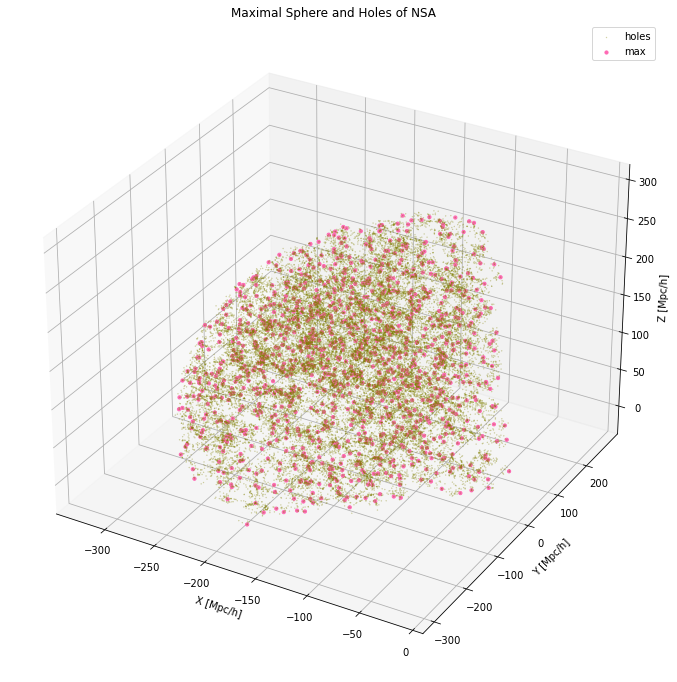

In [19]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(data_table_NSA['x'],data_table_NSA['y'], data_table_NSA['z'],
           color = 'olive', s=0.1, alpha=0.5,
           label='holes')
ax.scatter(data_table_NSA_max['x'],data_table_NSA_max['y'], data_table_NSA_max['z'],
           color = 'hotpink', s=10, alpha=1.0,
           label='max')
ax.set(xlabel='X [Mpc/h]', ylabel='Y [Mpc/h]', zlabel='Z [Mpc/h]')

ax.legend(loc='upper right', fontsize=10)

plt.title("Maximal Sphere and Holes of NSA");

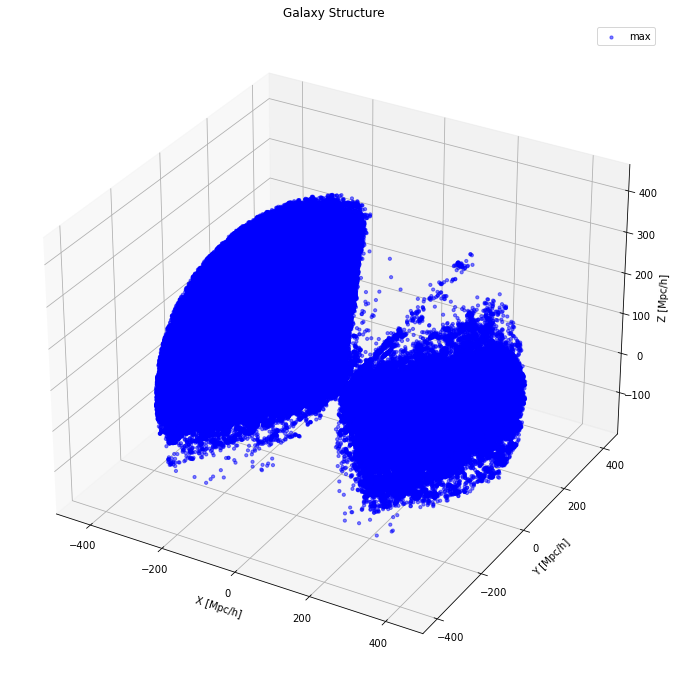

In [20]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(data_table_vl['x'],data_table_vl['y'], data_table_vl['z'],
           color = 'blue', s=10, alpha=0.5,
           label='max')
ax.set(xlabel='X [Mpc/h]',
       ylabel='Y [Mpc/h]',
       zlabel='Z [Mpc/h]')

ax.legend(loc='upper right', fontsize=10)
plt.title("Galaxy Structure");

In [21]:
def calc_volume_boundaries(void_cat_A, void_cat_B):
    """Compute the boundaries of the minimal rectangular volume (parallelpiped)
    that completely contains two void catalogs.
    
    Parameters
    ----------
    void_cat_A : astropy.Table
        Table of void data from first catalog.
    void_cat_B : astropy.Table
        Table of void data from second catalog.
        
    Returns
    -------
    x_min : float
    x_max : float
    y_min : float
    y_max : float
    z_min : float
    z_max : float
    """
    x_min = np.minimum(np.min(void_cat_A['x']), np.min(void_cat_B['x']))
    x_max = np.maximum(np.max(void_cat_A['x']), np.max(void_cat_B['x']))
    
    y_min = np.minimum(np.min(void_cat_A['y']), np.min(void_cat_B['y']))
    y_max = np.maximum(np.max(void_cat_A['y']), np.max(void_cat_B['y']))

    z_min = np.minimum(np.min(void_cat_A['z']), np.min(void_cat_B['z']))
    z_max = np.maximum(np.max(void_cat_A['z']), np.max(void_cat_B['z']))

    return x_min, x_max, y_min, y_max, z_min, z_max

def generate_grid_points(x_min, x_max, y_min, y_max, z_min, z_max):
    """Creates a dense rectangular grid of points in 3D for the void volume calculation.
    
    Returns
    -------
    xyz : list
        2D list of points in 3D space.
    """
    x_range = np.arange(x_min, x_max)
    y_range = np.arange(y_min, y_max)
    z_range = np.arange(z_min, z_max)

    # Creating a meshgrid from the ranges to 
    X,Y,Z = np.meshgrid(x_range,y_range,z_range)

    x_points = np.ravel(X)
    y_points = np.ravel(Y)
    z_points = np.ravel(Z)
    
    point_coords = np.array([x_points, y_points, z_points])
    
    return point_coords

In [22]:
#This line creates the boundaries (like the whole min and max)
xmin, xmax, ymin, ymax, zmin, zmax = calc_volume_boundaries(data_table_NSA, data_table_vl)

#This line makes creates the points in between 
pts = generate_grid_points(xmin, xmax, ymin, ymax, zmin, zmax)

b = pts.shape
print(b)

(3, 415392705)


In [23]:
# This is the cell to filter out all the points that we do not want 🥴
start_time = time.time()

rmin = 0
rmax = 332.38565

points_boolean = np.ones(pts.shape[1], dtype = bool)

print(time.time() - start_time)

start_time = time.time()
for i in range(pts.shape[1]):
    
    #   print(pts[:,i].reshape((1,3)).shape)
    #   print(pts[:,i].reshape((1,3)))
    #   print(pts[:,i])
    points_boolean[i] = not_in_mask(pts[:,i].reshape((1,3)), mask, mask_resolution, rmin, rmax)        


points_in_mask = pts[:,~points_boolean]
(var, n_points) = points_in_mask.shape
print(time.time() - start_time)
print(points_in_mask.shape)
print(np.sum(points_boolean))
print(np.sum(~points_boolean))
print(points_boolean.shape)

0.16825294494628906
2855.233623981476
(3, 27713423)
387679282
27713423
(415392705,)


3.677422046661377


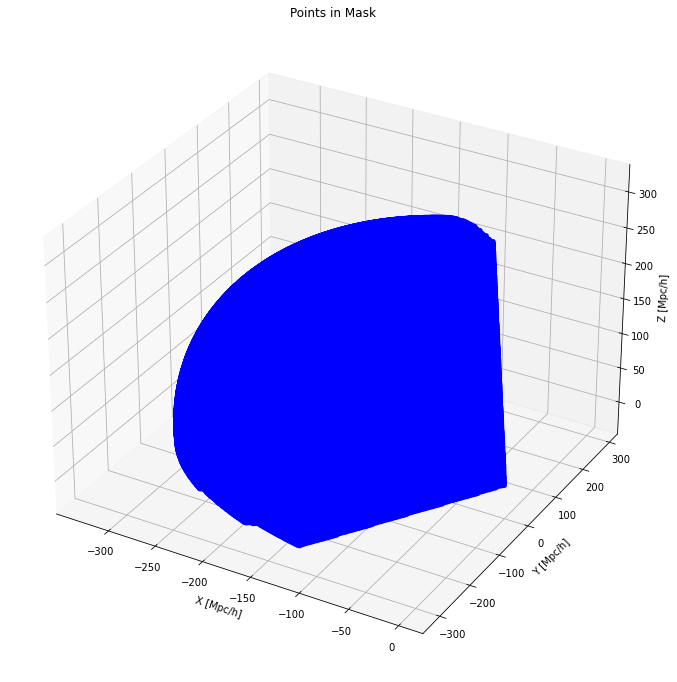

In [24]:
# should give me my good cone shape
start_time = time.time()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(points_in_mask[0,:],points_in_mask[1,:], points_in_mask[2,:],
           color = 'blue', s=10, alpha=0.5,
           label='max')
ax.set(xlabel='X [Mpc/h]',
       ylabel='Y [Mpc/h]',
       zlabel='Z [Mpc/h]')

plt.title("Points in Mask");
print(time.time() - start_time)

In [25]:
def point_query(point_coords, void_cat, vf):
    """We are creating a function to make a KDTree to find the number of points in 
    and out of a catalogue.
    
    Parameters
    ----------
    point_coords: ndarray has a shape of (3,N)
        This is the list of points to query the given void catalogue. N is the number of points given. 
    void_cat: Astropy Table
        This is the given void catalogue.
    vf: boolean 
        This tells me if my catalog is a VoidFinder catalog or not.
    
    Returns
    -------
    true_inside: ndarray of shape (N,1)
        Is this the boolean array of length N (same length as point_coords). True means that 1 point 
        is inside the hole.
    """
    
    cx = void_cat['x']
    cy = void_cat['y']
    cz = void_cat['z']

    sphere_coords = np.array([cx, cy, cz])

    start_time = time.time()

    #The .T is meant to transpose the array from (3,1054) to (1054,3)
    sphere_tree = neighbors.KDTree(sphere_coords.T)

    print(time.time() - start_time)

    start_time = time.time()

    dist, idx = sphere_tree.query(point_coords.T, k = 1)

    if vf:

        true_inside = dist < void_cat['radius'][idx]
    
    else: 
        """What goes into the square braket is whatever the name of the column that tells
        me what is in a wall and what in a void
        
        May need adjust 
        """

        true_inside = void_cat["V2"][idx] 
    
    return true_inside

In [26]:
start_time = time.time()

true_inside_NSA = point_query(points_in_mask, data_table_NSA, True)

count_in_NSA = np.sum(true_inside_NSA)

# The "~" inverts the array. So we have true_inside inverted to add up the falses instead of the trues
count_out_NSA = np.sum(~true_inside_NSA)
print(time.time() - start_time)

total_NSA = count_in_NSA + count_out_NSA

true_inside_vl = point_query(points_in_mask, data_table_vl, False)

count_in_vl = np.sum(true_inside_vl)

# The "~" inverts the array. So we have true_inside inverted to add up the falses instead of the trues
count_out_vl = np.sum(~true_inside_vl)

total_vl = count_in_vl + count_out_vl

print(time.time() - start_time)
print('\nNumber of points inside NSA VoidFinder: {}'.format(count_in_NSA))
print('\nNumber of points outside NSA VoidFinder: {}'.format(count_out_NSA))
print('\nNumber of points inside NSA V2: {}'.format(count_in_vl))
print('\nNumber of points outside NSA V2: {}'.format(count_out_vl))
print("\nThis is the total number of points: {}".format(total_vl))
# print("\nThis is the total number of points in NSA: {}".format(total_NSA))

0.02209305763244629
54.58035922050476
0.24974489212036133
120.84870409965515

Number of points inside NSA VoidFinder: 15668435

Number of points outside NSA VoidFinder: 12044988

Number of points inside NSA V2: 17445383

Number of points outside NSA V2: 10268040

This is the total number of points: 27713423


In [27]:
start_time = time.time()

U = 21

count_in_NSA = np.zeros(U)
count_out_NSA = np.zeros(U)

count_in_vl = np.zeros(U)
count_out_vl = np.zeros(U)

inside_both = np.zeros(U)
inside_neither = np.zeros(U)
inside_a = np.zeros(U)
inside_b = np.zeros(U)

points_in_mask_copy = points_in_mask.copy()

for i in range(U):
        
    delta = np.random.rand(3)
    
    points_in_mask_copy[0] = points_in_mask[0] + delta[0]
    points_in_mask_copy[1] = points_in_mask[1] + delta[1]
    points_in_mask_copy[2] = points_in_mask[2] + delta[2]
    
    true_inside_NSA = point_query(points_in_mask_copy, data_table_NSA, True)

    count_in_NSA[i] = np.sum(true_inside_NSA)

    # The "~" inverts the array. So we have true_inside inverted to add up the falses instead of the trues
    count_out_NSA[i] = np.sum(~true_inside_NSA)
    
    # print(time.time() - start_time)

    # total_KIAS = count_in_KIAS + count_out_KIAS

    true_inside_vl = point_query(points_in_mask_copy, data_table_vl, False)

    count_in_vl[i] = np.sum(true_inside_vl)

    # The "~" inverts the array. So we have true_inside inverted to add up the falses instead of the trues
    count_out_vl[i] = np.sum(~true_inside_vl)

    #total_DEL = count_in_DEL + count_out_DEL
    
    # This is the number of points that are inside both A and B
    inside_A_and_B = np.logical_and(true_inside_NSA, true_inside_vl)
    inside_both[i] = np.sum(inside_A_and_B)
    
    # This is the number of points that are in neither A and B
    not_inside_A_and_B = np.logical_and(~true_inside_NSA, ~true_inside_vl)
    inside_neither[i] = np.sum(not_inside_A_and_B)
    
    # This is the number of points that are in A but not B
    inside_A = np.logical_and(true_inside_NSA, ~true_inside_vl)
    inside_a[i] = np.sum(inside_A)
    
    # This is the number of points that are not in A but are in B
    inside_B = np.logical_and(~true_inside_NSA, true_inside_vl)
    inside_b[i] = np.sum(inside_B)
    
print(time.time() - start_time)
print('\nNumber of points inside KIAS:', count_in_NSA)
print('\nNumber of points outside KIAS:', count_out_NSA)
print('\nNumber of points inside Delaunay:', count_in_vl)
print('\nNumber of points outside Delaunay:', count_out_vl)
print("\nThis is the total number of points: {}".format(n_points))
# print("\nThis is the total number of points in Delaunay: {}".format(total_DEL))

0.018561124801635742
0.26370811462402344
0.01446986198425293
0.25725817680358887
0.016210079193115234
0.23992395401000977
0.014614105224609375
0.23403596878051758
0.014470100402832031
0.24205732345581055
0.015293121337890625
0.24218106269836426
0.0146331787109375
0.23405098915100098
0.014955997467041016
0.23619484901428223
0.015257120132446289
0.2515439987182617
0.014659881591796875
0.2498798370361328
0.014703989028930664
0.2763631343841553
0.016281843185424805
0.23839688301086426
0.014503240585327148
0.2481379508972168
0.014487743377685547
0.2470409870147705
0.014383792877197266
0.2391190528869629
0.014466047286987305
0.23961973190307617
0.014954090118408203
0.23621106147766113
0.01455378532409668
0.2384016513824463
0.014719009399414062
0.2351360321044922
0.016299962997436523
0.2504730224609375
0.014568805694580078
0.23735666275024414
2599.864100217819

Number of points inside KIAS: [15664340. 15669640. 15670062. 15671514. 15664576. 15665253. 15671635.
 15668665. 15668225. 15671699. 1

## This is the number of points that are inside both A and B

In [28]:
inside_A_and_B = np.logical_and(true_inside_vl, true_inside_NSA)

np.sum(inside_A_and_B), count_in_vl, count_in_NSA

(10392041,
 array([17454711., 17451997., 17449153., 17437397., 17458991., 17458398.,
        17439796., 17445440., 17454740., 17442303., 17436073., 17437440.,
        17445854., 17444222., 17445768., 17448463., 17452802., 17442572.,
        17455933., 17432417., 17431326.]),
 array([15664340., 15669640., 15670062., 15671514., 15664576., 15665253.,
        15671635., 15668665., 15668225., 15671699., 15673881., 15673203.,
        15669159., 15672584., 15672060., 15668338., 15666275., 15671506.,
        15664114., 15670722., 15671653.]))

## This is the number of points that are in neither A and B


In [29]:
not_inside_A_and_B = np.logical_and(~true_inside_NSA, ~true_inside_vl)

np.sum(not_inside_A_and_B), count_in_vl, count_in_NSA

(5002485,
 array([17454711., 17451997., 17449153., 17437397., 17458991., 17458398.,
        17439796., 17445440., 17454740., 17442303., 17436073., 17437440.,
        17445854., 17444222., 17445768., 17448463., 17452802., 17442572.,
        17455933., 17432417., 17431326.]),
 array([15664340., 15669640., 15670062., 15671514., 15664576., 15665253.,
        15671635., 15668665., 15668225., 15671699., 15673881., 15673203.,
        15669159., 15672584., 15672060., 15668338., 15666275., 15671506.,
        15664114., 15670722., 15671653.]))

## This is the number of points that are in A but not B

In [30]:
inside_A = np.logical_and(true_inside_NSA, ~true_inside_vl)

np.sum(inside_A)

5279612

## This is the number of points that are not in A but are in B

In [31]:
inside_B = np.logical_and(~true_inside_NSA, true_inside_vl)

np.sum(inside_B)

7039285

# Fraction of points: Calculate the ratios of the given sums

- in A
- in B
- in A & B
- in neither A nor B
- {in A, not B
- {in B, not A
-   |
-   |
- \ /
- The closer they are to zero, the more similar they are

## This is the ratio of A

In [32]:
r_A = count_in_NSA / n_points
print(r_A)

[0.56522574 0.56541698 0.56543221 0.5654846  0.56523425 0.56525868
 0.56548897 0.5653818  0.56536592 0.56549128 0.56557001 0.56554555
 0.56539963 0.56552321 0.5655043  0.56537    0.56529556 0.56548431
 0.56521758 0.56545602 0.56548962]


## This is the ratio of B


In [33]:
r_B = count_in_vl / n_points
print(r_B)

[0.62982877 0.62973083 0.62962821 0.62920401 0.6299832  0.62996181
 0.62929058 0.62949423 0.62982981 0.62938104 0.62915624 0.62920557
 0.62950917 0.62945028 0.62950607 0.62960332 0.62975988 0.62939075
 0.62987286 0.62902432 0.62898495]


## This is the ratio of A & B

In [34]:
r_AB = np.sum(inside_A_and_B) / n_points
print(r_AB)

0.3749822243177972


## This is the ratio of neither A nor B


In [35]:
r_notAB = np.sum(not_inside_A_and_B) / n_points
print(r_notAB)

0.1805076550810775


## This is the ratio of A and not B

In [36]:
r_A_not_B = np.sum(inside_A) / n_points
print(r_A_not_B)

0.1905073941966678


## This is the ratio of B and not A


In [37]:
r_B_not_A = np.sum(inside_B) / n_points
print(r_B_not_A)

0.25400272640445754


In [38]:
Sum = r_AB + r_notAB + r_A_not_B + r_B_not_A
Sum

1.0

# This will be the Standard Deviation and Mean of the Data


## This is the STD and Mean of VoidFinder

In [39]:
average_vf = np.mean(count_in_NSA)
r_average_vf = average_vf / n_points

std_vf = np.std(count_in_NSA)
r_std_vf = std_vf / n_points

print(r_average_vf)
print(std_vf )
print(r_std_vf)

0.5654112500955636
2968.149452111202
0.00010710151005565795


## This is the STD and Mean of V2


In [40]:
average_vl = np.mean(count_in_vl)
r_average_vl = average_vl / n_points

std_vl = np.std(count_in_vl)
r_std_vl = std_vl / n_points

print(r_average_vl)
print(std_vl )
print(r_std_vl)

0.6295140909051288
8120.404752654807
0.0002930134163742533


## This is the STD and Mean of Both 


In [41]:
average_both = np.mean(inside_both)
r_average_both = average_both / n_points

std_both = np.std(inside_both)
r_std_both = std_both / n_points

print(r_average_both)
print(std_both )
print(r_std_both)

4.632
0.0023

0.3750946401883098
1555.252133025032
5.611909192974942e-05


0.0023

In [42]:
average_neither = np.mean(inside_neither)
r_average_neither = average_neither / n_points

std_neither = np.std(inside_neither)
r_std_neither = std_neither / n_points

print(r_average_neither)
print(std_neither )
print(r_std_neither)


0.18016929918761748
4422.898381744498
0.0001595940848499479


In [43]:
average_a = np.mean(inside_a)
r_average_a = average_a / n_points

std_a = np.std(inside_a)
r_std_a = std_a / n_points

print(r_average_a)
print(std_a )
print(r_std_a)

0.19031660990725377
4169.725686339538
0.00015045870321899745


In [44]:
average_b = np.mean(inside_b)
r_average_b = average_b / n_points

std_b = np.std(inside_b)
r_std_b = std_b / n_points

print(r_average_b)
print(std_b )
print(r_std_b)

0.254419450716819
6698.692568139621
0.00024171292619246711
